In [121]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor



In [81]:
contracts = pd.read_csv("rental_contracts.csv")

contracts.head()

,Room Title,Property Id,Start Date,End Date,Created Date,Signed Date,Host Name,Host Client Name,Renter Name,Renter Client Name,...,Guest Bathroom,Room Rent,Room Utilities,City,Province,Zip Code,Home Details,Admin Notes,Created At,Updated At
0,Close to all amenities! Close to transit!,29,2025-11-26,2027-11-24,2025-05-16,2025-05-16,Jane Dou,Happipad,Jane Dou,Happipad,...,NaN,850,0.0,Kelowna,BC,V1X7H3,Property Type: Apartment;\nHousehold Items: Co...,NaN,2025-05-16,2025-05-16
1,Close to all amenities! Close to transit!,29,2025-01-01,2025-11-26,2025-05-16,2025-05-16,Jane Dou,Happipad,Jane Dou,Happipad,...,NaN,850,0.0,Kelowna,BC,V1X7H3,Property Type: Apartment;\nHousehold Items: Co...,NaN,2025-05-16,2025-05-16
2,"Large, open-concept, with private bathroom and...",3378,2025-09-01,2025-11-30,2025-05-01,2025-05-01,Jane Dou,Happipad,Jane Dou,Happipad,...,NaN,1000,0.0,Kelowna,BC,V1Y5T1,Property Type: Townhouse;\nFurnishings: Beddin...,NaN,2025-05-01,2025-05-03
3,Room for a UBC student.,815,2025-06-01,2025-09-30,2025-05-01,2025-05-02,Jane Dou,Happipad,Jane Dou,Happipad,...,NaN,525,0.0,Kelowna,BC,V1X2P1,"Property Type: House;\nFurnishings: Desk, Hang...",NaN,2025-05-01,2025-05-04
4,Walkout Basement Accomo in Lakeview Heights wi...,1766,2025-05-01,2025-10-31,2025-04-29,2025-04-29,Jane Dou,Happipad,Jane Dou,Happipad,...,NaN,1025,0.0,West Kelowna,BC,V1Z1W5,Property Type: House;\nFacilities: Common loun...,NaN,2025-04-29,2025-04-29


In [83]:
# Dictionary mapping full province names to abbreviations
province_map = {
    'Alberta': 'AB',
    'British Columbia': 'BC',
    'Manitoba': 'MB',
    'New Brunswick': 'NB',
    'Newfoundland and Labrador': 'NL',
    'Nova Scotia': 'NS',
    'Ontario': 'ON',
    'Prince Edward Island': 'PE',
    'Quebec': 'QC',
    'Saskatchewan': 'SK',
    'Northwest Territories': 'NT',
    'Nunavut': 'NU',
    'Yukon': 'YT'
}

# Add abbreviations to the dictionary so they don't get changed
province_map.update({abbr: abbr for abbr in province_map.values()})

# Standardize all values in the Province column
contracts['Province'] = contracts['Province'].map(province_map)

# Check if there are any unmapped provinces (e.g., typos)
unmapped = contracts[contracts['Province'].isna()]
if not unmapped.empty:
    print(" Unmapped values found in Province column:")
    print(unmapped['Province'].unique())


In [85]:
# Display the unique values of the Province column

print(contracts['Province'].unique())

['BC' 'NS' 'AB' 'ON' 'NB' 'MB']


In [87]:
# Identify all date columns

date_columns = [
    'Start Date', 'End Date', 'Created Date', 'Signed Date',
    'Contract Termination Date', 'Deadline', 'Created At', 'Updated At'
]

# Convert these values to datetimes

for col in date_columns:
    contracts[col] = pd.to_datetime(contracts[col], errors='coerce')

# Check that datatypes were correctly converted 

print(contracts[date_columns].dtypes)


Start Date                   datetime64[ns]
End Date                     datetime64[ns]
Created Date                 datetime64[ns]
Signed Date                  datetime64[ns]
Contract Termination Date    datetime64[ns]
Deadline                     datetime64[ns]
Created At                   datetime64[ns]
Updated At                   datetime64[ns]
dtype: object


In [89]:
# Separate Home Details column into multiple variables 

from sklearn.preprocessing import MultiLabelBinarizer

# Function to extract list-based items from Home Details column
def extract_items(text, label):
    match = pd.Series(text).str.extract(rf'{label}:\s*(.*?);')[0]
    return match.fillna('').str.split(r',\s*')

# Extract the categories into list columns
contracts['Furnishings_list'] = extract_items(contracts['Home Details'], 'Furnishings')
contracts['Safety Features_list'] = extract_items(contracts['Home Details'], 'Safety Features')
contracts['Amenities_list'] = extract_items(contracts['Home Details'], 'Amenities')
contracts['House Rules_list'] = extract_items(contracts['Home Details'], 'House Rules')

# Function to one-hot encode list-based columns
def binarize_column(df, column_name, prefix):
    mlb = MultiLabelBinarizer()
    transformed = pd.DataFrame(
        mlb.fit_transform(df[column_name]),
        columns=[f'{prefix}: {item}' for item in mlb.classes_],
        index=df.index
    )
    return transformed

# One-hot encode each list column
furnishings_ohe = binarize_column(contracts, 'Furnishings_list', 'Furnishing')
safety_ohe = binarize_column(contracts, 'Safety Features_list', 'Safety')
amenities_ohe = binarize_column(contracts, 'Amenities_list', 'Amenity')
rules_ohe = binarize_column(contracts, 'House Rules_list', 'Rule')

# --- Extract single-value fields like 'Bed Type' and 'Property Type'
contracts['Bed Type'] = contracts['Home Details'].str.extract(r'Bed Type:\s*([^;]+)')
contracts['Property Type'] = contracts['Home Details'].str.extract(r'Property Type:\s*([^;]+)')

# Combine one-hot columns with the original DataFrame
contracts = pd.concat([contracts, furnishings_ohe, safety_ohe, amenities_ohe, rules_ohe], axis=1)

# Drop intermediate list columns
contracts.drop(columns=['Furnishings_list', 'Safety Features_list', 'Amenities_list', 'House Rules_list'], inplace=True)





In [91]:
# Remove rows where 'Room Title' contains 'test' (case-insensitive)
contracts = contracts[~contracts['Room Title'].str.contains('test|demo', case=False, na=False)]

# Remove postal code spaces and convert to uppercase
contracts['Zip Code'] = contracts['Zip Code'].str.replace(r'\s+', '', regex=True).str.upper()

# Define a regex pattern for valid Canadian postal codes
postal_code_pattern = r'^[A-Z]\d[A-Z]\d[A-Z]\d$'

# Replace invalid postal codes with NaN
contracts['Zip Code'] = contracts['Zip Code'].where(contracts['Zip Code'].str.match(postal_code_pattern))

num_valid_postal_codes = contracts['Zip Code'].str.match(postal_code_pattern).sum()
print(f"Number of valid postal codes: {num_valid_postal_codes}")

contracts.head(3)

Number of valid postal codes: 592


,Room Title,Property Id,Start Date,End Date,Created Date,Signed Date,Host Name,Host Client Name,Renter Name,Renter Client Name,...,Amenity: Microwave,Amenity: Private entry,Amenity: Stove and oven,Amenity: Street parking,Amenity: Swimming pool,Amenity: Tv,Amenity: Washer,Amenity: Window covering,Amenity: wifi,Rule:
0,Close to all amenities! Close to transit!,29,2025-11-26,2027-11-24,2025-05-16,2025-05-16,Jane Dou,Happipad,Jane Dou,Happipad,...,1,1,1,1,0,1,1,1,1,1
1,Close to all amenities! Close to transit!,29,2025-01-01,2025-11-26,2025-05-16,2025-05-16,Jane Dou,Happipad,Jane Dou,Happipad,...,1,1,1,1,0,1,1,1,1,1
2,"Large, open-concept, with private bathroom and...",3378,2025-09-01,2025-11-30,2025-05-01,2025-05-01,Jane Dou,Happipad,Jane Dou,Happipad,...,1,1,1,1,0,1,1,1,1,1


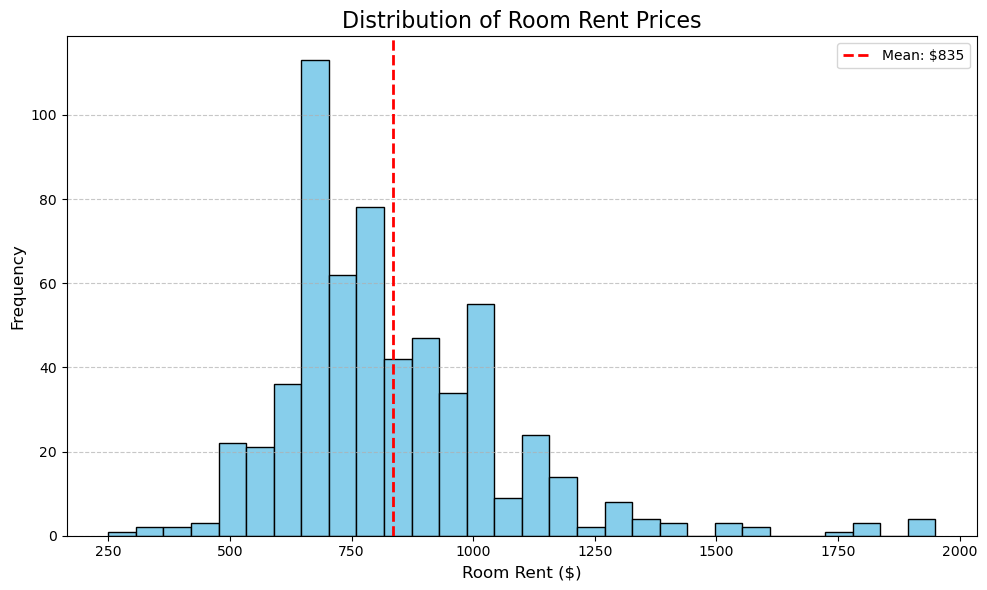

In [93]:
import matplotlib.pyplot as plt

#Plot the distribution of room rents to understand it further

# Drop NaNs 
room_rent = contracts['Room Rent'].dropna()

#create plot 
plt.figure(figsize=(10, 6))
plt.hist(room_rent, bins=30, color='skyblue', edgecolor='black')

# Plot mean line
plt.axvline(room_rent.mean(), color='red', linestyle='dashed', linewidth=2, label=f'Mean: ${room_rent.mean():.0f}')

# Titles and labels
plt.title('Distribution of Room Rent Prices', fontsize=16)
plt.xlabel('Room Rent ($)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()

plt.tight_layout()
plt.show()

#This shows somewhat of a normal distribution. However, there are extreme outliers that need to be discussed with Amine.
#These include rents that are near $0 or near $2500


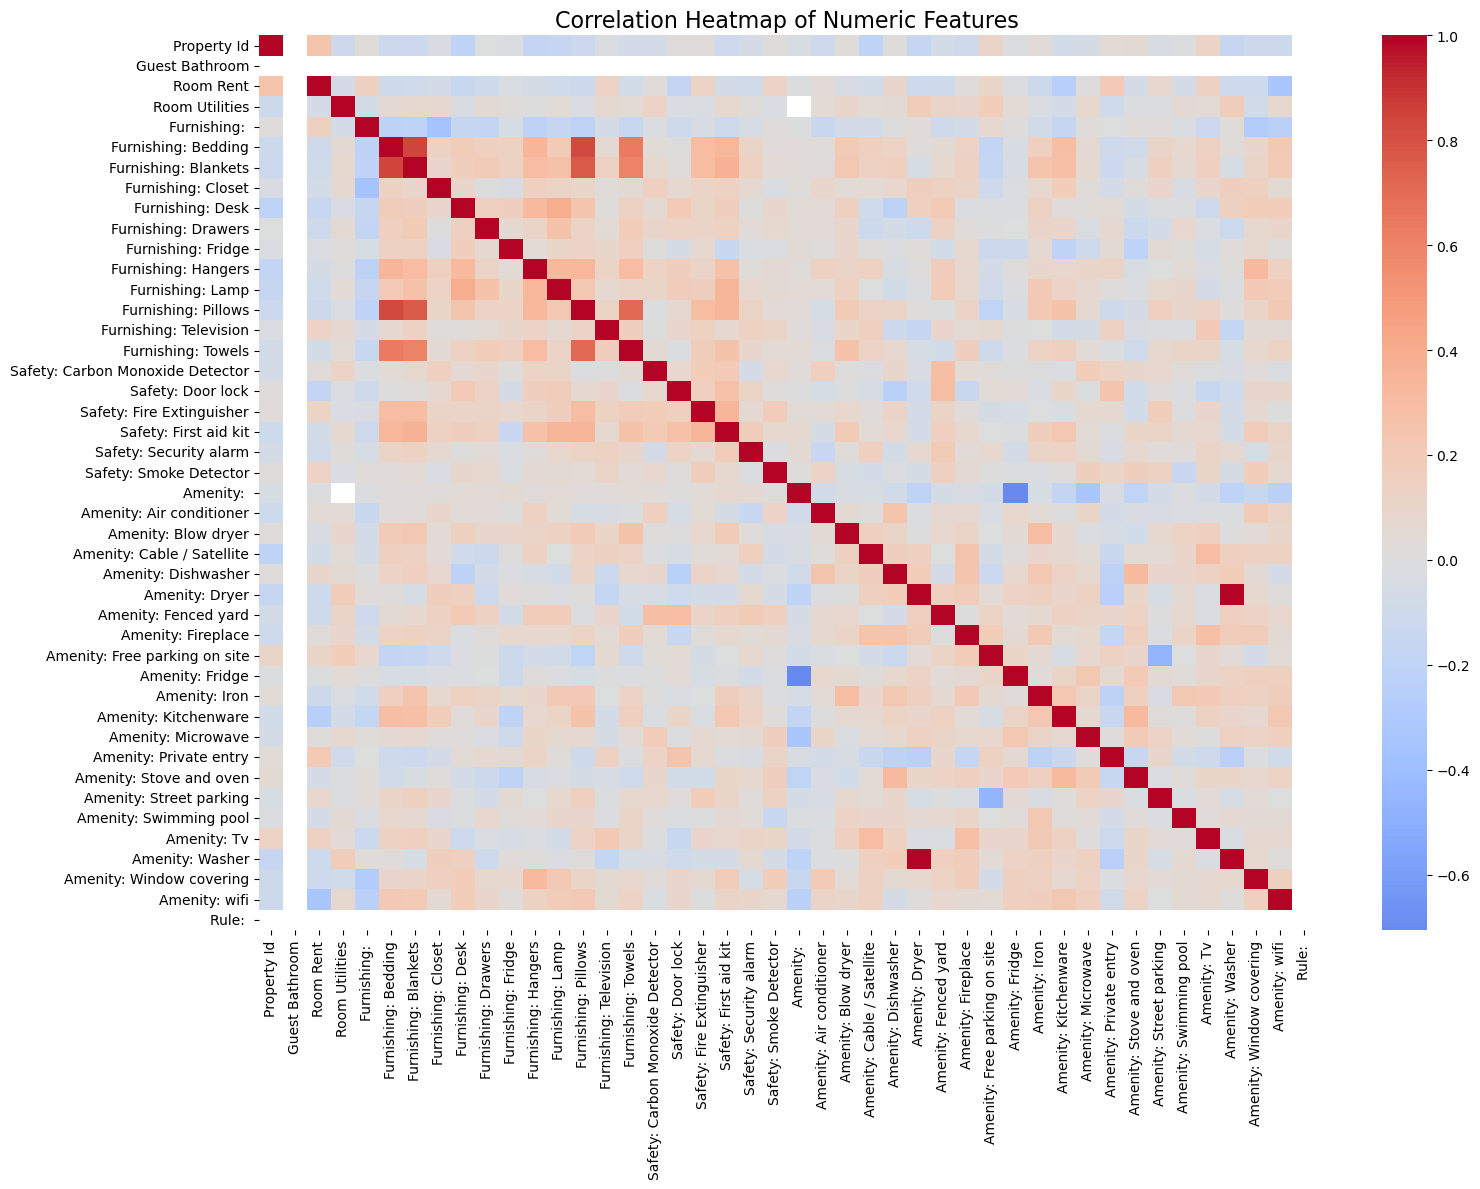

In [95]:
#investigate correlation between variables

# Select only numeric columns (important: include one-hot and engineered features too)
numeric_features = contracts.select_dtypes(include='number')

#compute correlation matrix
corr_matrix = numeric_features.corr()

# Plot heatmap
plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False, fmt='.2f', center=0)
plt.title('Correlation Heatmap of Numeric Features', fontsize=16)
plt.tight_layout()
plt.show()

#One immediate insight from this plot is that bedding is highly correlated with blankets, and washing machine is highly correlated with dryer machine.
#This intuitively makes sense, and indicates we might be better off only including one of each of these highly correlated
#pairs in our analyses


Bed Type
Queen bed     248
Double bed    173
Single bed     92
Twin bed       45
King bed       21
Name: count, dtype: int64
Property Type
House          400
Apartment       83
Townhouse       68
Suite           38
Mobile Home      6
Name: count, dtype: int64


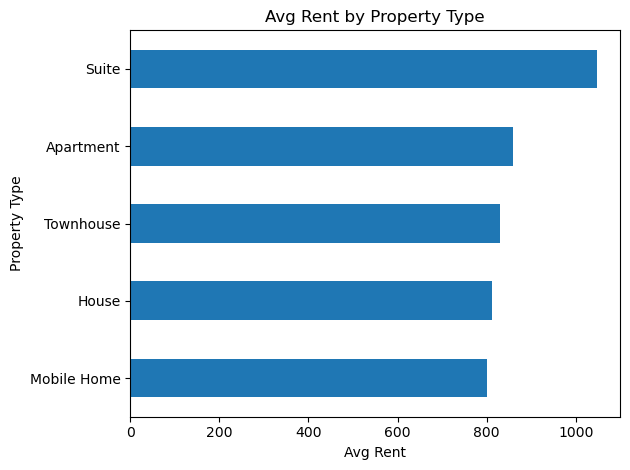

In [97]:
#display bed types and property types

print(contracts['Bed Type'].value_counts())
print(contracts['Property Type'].value_counts())

# Mean rent by property type
contracts.groupby('Property Type')['Room Rent'].mean().sort_values().plot(kind='barh', title='Avg Rent by Property Type')
plt.xlabel('Avg Rent')
plt.tight_layout()
plt.show()


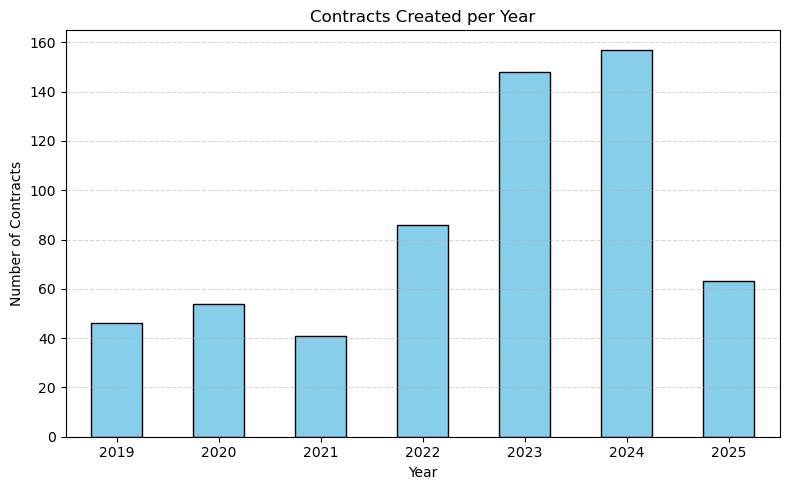

In [99]:
#Investigate how many contracts were created in each year

# Extract year
contracts['Created Year'] = contracts['Created Date'].dt.year

# Count contracts per year
yearly_counts = contracts['Created Year'].value_counts().sort_index()

# Plot
plt.figure(figsize=(8, 5))
yearly_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Contracts Created per Year')
plt.xlabel('Year')
plt.ylabel('Number of Contracts')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()



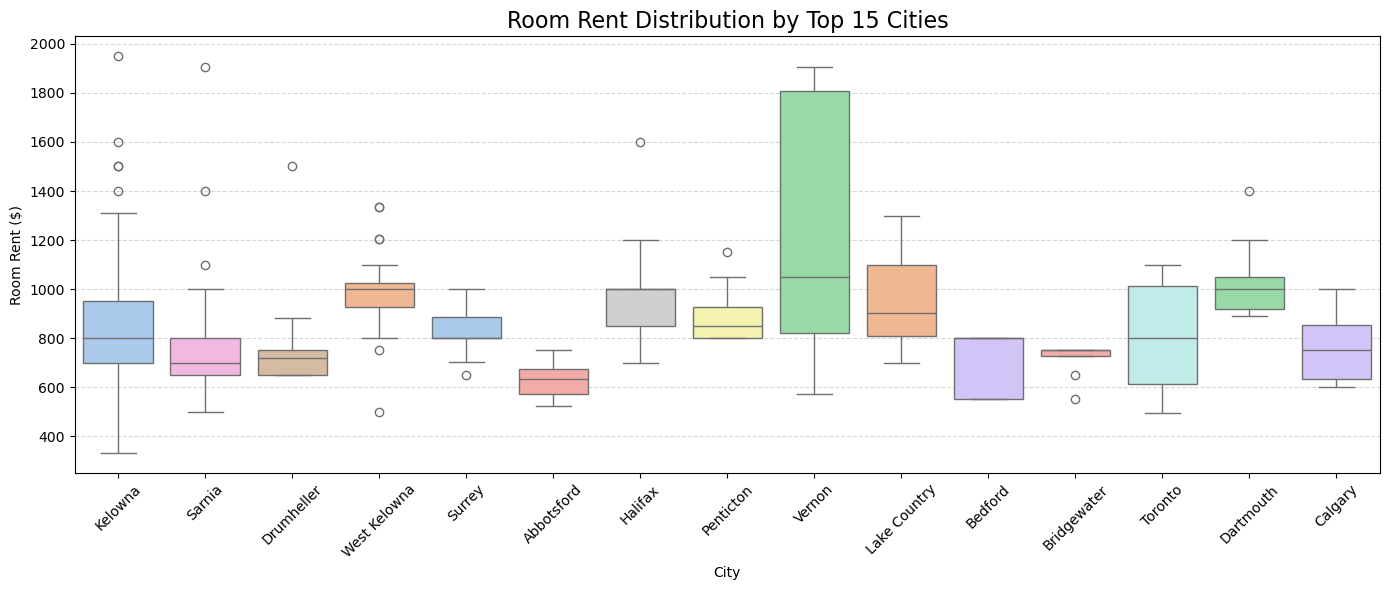

In [101]:

# Get the top 15 cities by number of contracts
top_cities = contracts['City'].value_counts().nlargest(15)

# Filter contracts for only the top 15 cities
contracts_top_cities = contracts[contracts['City'].isin(top_cities.index)]

plt.figure(figsize=(14, 6))
sns.boxplot(
    data=contracts_top_cities,
    x='City',
    y='Room Rent',
    hue='City',
    palette='pastel',
    order=top_cities.index,   # <-- sort by number of contracts
    legend=False
)

plt.title('Room Rent Distribution by Top 15 Cities', fontsize=16)
plt.ylabel('Room Rent ($)')
plt.xlabel('City')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [103]:
#Create new column for length of contract 

from dateutil.relativedelta import relativedelta

def diff_months_rounded(end, start):
    rd = relativedelta(end, start)
    total_months = rd.years * 12 + rd.months
    # Round up if 15 or more days
    if rd.days >= 15:
        total_months += 1
    return total_months

contracts['Contract Length (months, rounded)'] = contracts.apply(
    lambda row: diff_months_rounded(row['End Date'], row['Start Date']), axis=1
)


In [105]:
contracts['Contract Length (months, rounded)'].head()

0    24
1    11
2     3
3     4
4     6
Name: Contract Length (months, rounded), dtype: int64

In [133]:
contracts['Contract Length (months, rounded)'].value_counts()


Contract Length (months, rounded)
 4     98
 1     76
 2     69
 3     67
 8     51
 6     41
 12    37
 5     35
 7     23
 9     17
 11    15
 0     15
 13    12
 10    10
 17     4
 18     4
 16     4
 24     3
 14     2
 15     2
-1      2
 21     2
 20     1
 19     1
 29     1
 23     1
 26     1
 37     1
Name: count, dtype: int64

In [107]:
# Prepare data for initial modelling 


# Target coding is used first instead of one-hot encoding for the city variable,
# to help prevent overfitting and computational requirements 

# 1. Target encode 'City'
city_target_mean = contracts.groupby('City')['Room Rent'].mean()
contracts['City_TE'] = contracts['City'].map(city_target_mean)

# 2. One-hot encode 'Province', 'Bed Type', 'Property Type'
contracts = pd.get_dummies(
    contracts,
    columns=['Province', 'Bed Type', 'Property Type'],
    drop_first=True
)

# 3. Drop unneeded columns
X = contracts.drop(columns=[
    'Room Rent', 'Property Id', 'Admin Notes', 'Created At', 'Updated At',
    'Room Title', 'End Date', 'Created Date', 'Signed Date', 'Host Name',
    'Host Client Name', 'Renter Name', 'Renter Client Name',
    'Contract Termination Date', 'Status', 'Was Accepted', 'Was Withdrawn',
    'Application Has Expired', 'Deadline', 'Guest Bathroom', 'Room Utilities',
    'Zip Code', 'Home Details', 'City', 'Start Date'  
], errors='ignore')

# 4. Target variable
y = contracts['Room Rent']

# 5. Fill any missing numeric values (if any)
X = X.fillna(0)

# 6. Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 7. Train XGBoost model
model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=200,
    learning_rate=0.1,
    max_depth=6,
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train)

# 8. Evaluate
y_pred = model.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f'RMSE on test set: {rmse:.2f}')
print(f"Mean Room Rent: ${contracts['Room Rent'].mean():.2f}")



RMSE on test set: 134.89
Mean Room Rent: $834.86


C:\Users\Foste\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [115]:
relative_error = ((134.89/834.86) * 100)
print(f'RMSE of $134.89 is ~ {relative_error:.2f}% relative error')

RMSE of $134.89 is ~ 16.16% relative error


In [117]:
# One-hot encode City, Province, Bed Type, Property Type 
cols_to_encode_v2 = [col for col in ['City', 'Province', 'Bed Type', 'Property Type'] if col in contracts.columns]

if cols_to_encode_v2:
    contracts_v2 = pd.get_dummies(contracts.copy(), columns=cols_to_encode_v2, drop_first=True)
else:
    contracts_v2 = contracts.copy()
    
# Define features and target for new version
X_v2 = contracts_v2.drop(columns=[
    'Room Rent', 'Property Id', 'Admin Notes', 'Created At', 'Updated At',
    'Room Title', 'End Date', 'Created Date', 'Signed Date', 'Host Name',
    'Host Client Name', 'Renter Name', 'Renter Client Name',
    'Contract Termination Date', 'Status', 'Was Accepted', 'Was Withdrawn',
    'Application Has Expired', 'Deadline', 'Guest Bathroom', 'Room Utilities',
    'Zip Code', 'Home Details', 'Start Date'
], errors='ignore')

y_v2 = contracts_v2['Room Rent']

# Fill any missing values
X_v2 = X_v2.fillna(0)

# Train/test split for model v2
X_train_v2, X_test_v2, y_train_v2, y_test_v2 = train_test_split(
    X_v2, y_v2, test_size=0.2, random_state=42
)

# XGBoost model for version 2
model_v2 = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=200,
    learning_rate=0.1,
    max_depth=6,
    random_state=42,
    n_jobs=-1
)
model_v2.fit(X_train_v2, y_train_v2)

# Evaluation
y_pred_v2 = model_v2.predict(X_test_v2)
rmse_v2 = mean_squared_error(y_test_v2, y_pred_v2, squared=False)

print(f'[Model v2 - One-Hot City] RMSE on test set: {rmse_v2:.2f}')
print(f'[Model v2] Mean Room Rent: ${y_v2.mean():.2f}')


[Model v2 - One-Hot City] RMSE on test set: 137.16
[Model v2] Mean Room Rent: $834.86


C:\Users\Foste\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [119]:
relative_error_v2 = ((137.16/834.86) * 100)
print(f'RMSE of $137.16 is ~ {relative_error_v2:.2f}% relative error')

RMSE of $137.16 is ~ 16.43% relative error


In [129]:

# 1. Reuse the one-hot encoded DataFrame from earlier
contracts_rf = contracts_v2.copy()

# 2. Define features and target
X_rf = contracts_rf.drop(columns=[
    'Room Rent', 'Property Id', 'Admin Notes', 'Created At', 'Updated At',
    'Room Title', 'End Date', 'Created Date', 'Signed Date', 'Host Name',
    'Host Client Name', 'Renter Name', 'Renter Client Name',
    'Contract Termination Date', 'Status', 'Was Accepted', 'Was Withdrawn',
    'Application Has Expired', 'Deadline', 'Guest Bathroom', 'Room Utilities',
    'Zip Code', 'Home Details', 'Start Date'
], errors='ignore')

y_rf = contracts_rf['Room Rent']

# 3. Fill missing values
X_rf = X_rf.fillna(0)

# 4. Train/test split
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(
    X_rf, y_rf, test_size=0.2, random_state=42
)

# 5. Train Random Forest model
model_rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=12,
    random_state=42,
    n_jobs=-1
)
model_rf.fit(X_train_rf, y_train_rf)

# 6. Evaluate
y_pred_rf = model_rf.predict(X_test_rf)
rmse_rf = mean_squared_error(y_test_rf, y_pred_rf, squared=False)

print(f'[Model v3 - Random Forest] RMSE on test set: {rmse_rf:.2f}')
print(f'[Model v3] Mean Room Rent: ${y_rf.mean():.2f}')


[Model v3 - Random Forest] RMSE on test set: 123.68
[Model v3] Mean Room Rent: $834.86


C:\Users\Foste\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [131]:
relative_error_rf = ((123.68/834.86) * 100)
print(f'RMSE of $123.68 is ~ {relative_error_rf:.2f}% relative error')

RMSE of $123.68 is ~ 14.81% relative error
